In [5]:
#import talib as ta 
import pandas as pd
import numpy as np

# This funciton can be replaced by your trading strategy. 
# The function must one of the following three 
# 	1     - BUY
# 	0     - HOLD
# 	-1    - SELL
def trading_strategy(inputs):
	# This demo trading strategy is build on cross over of moving averages of 5 and 20 periods (data points) .
	df = pd.DataFrame(inputs)
	
	sma5_list = ta.SMA(df['close'] , 5)
	ema20_list = ta.EMA(df['close'] , 20)

	arr = np.array(sma5_list)
	df['sma5'] = arr.tolist()
	arr = np.array(ema20_list)
	df['ema20'] = arr.tolist()
	
	sma5 = df['sma5'].iloc[-1]
	ema20 = df['ema20'].iloc[-1]
	last_sma5 = df['sma5'].iloc[-2]
	last_ema20 = df['ema20'].iloc[-2]
	if ~np.isnan(last_sma5) and ~np.isnan(last_ema20):
		if (last_sma5 < last_ema20 and sma5 >= ema20):
			return 1  # buy
		elif (last_sma5 > last_ema20 and sma5 <= ema20):
			return -1 # sell 
		else:
			return 0 # do nothing


def trading_strategySD(inputs):	
	df = pd.DataFrame(inputs)
	current_std = df['close'][-3:len(df)].std()   # std of last 3 prices
	past_std = df['close'][-15:-3].std()

	if df['close'].iloc[-1] > df['close'][-15:-3].max() and current_std > 1.5 * past_std:
			return 1 # buy
	elif df['close'].iloc[-1] < df['close'][-15:-3].min() and current_std > 1.5 * past_std:
			return 1 # sell
	else:
		return 0
    
def trading_strategy_my(inputs,model):
    df = pd.DataFrame(inputs)
   
   
    last_close = df['close'].iloc[-1]
    np_input = df.iloc[:,1:19].values.reshape(1,20,18)
    
    
    data_input = torch.from_numpy(np_input).float()
		
    prediction_close = model(data_input).detach().numpy()
    if prediction_close-0.0002 > last_close:
        return 1
    elif prediction_close < last_close-0.0002:
        return -1
    else:
        return 0

In [2]:
class signalHandler:

    def __init__(self,stop_loss,take_profit,broker_cost,data):
        self.original_stop_loss = stop_loss
        self.original_take_profit = take_profit
        self.broker_cost = broker_cost
        self.stop_loss = stop_loss
        self.take_profit = take_profit

        self.prev_traded_position = 0
        self.prev_traded_price = None

        self.total_profit = 0
        data['action'] = ''
        data['P/L'] = ''
        data['Total profit'] = ''
        n = len(data)
        self.action = [""]*n
        self.arr_PL = [""]*n 
        self.arr_total_profit = [""]*n 
        self.current_action = ""
        self.data = data        

    ############### Helpers ###############

    # Floors or ceils PL 
    def bandPL(self,PL):
        if PL > self.take_profit:
            PL = self.take_profit
        elif PL < self.stop_loss:
            PL = self.stop_loss
        return PL

    # Only called when a trade happens
    def closeTrade(self,PL):
        # Reseting Current position,action AND toal profit
        if self.prev_traded_position == -1:
            self.current_action = "short_buy"
        elif self.prev_traded_position == 1:
            self.current_action = "sell"        
        
        self.total_profit += PL

        self.prev_traded_position = 0
        self.prev_traded_price = None

        self.stop_loss = self.original_stop_loss
        self.take_profit = self.original_take_profit
        
    # Called every iteration to ADD stats into an array.
    # These arrays will be later copied into a DATAFRAME
    def saveStats(self,PL,index):
                
        if self.prev_traded_position == 1:
            self.action[index] = self.current_action
        
        elif self.prev_traded_position == -1:
            self.action[index] = self.current_action
        
        elif self.prev_traded_position == 0:
            self.action[index] = self.current_action
        
        self.arr_PL[index] = PL
        self.arr_total_profit[index] = self.total_profit

    # Transfers all the data into the DATAFRAME
    # The constructor is initialised with
    def getData(self):
        self.data['action'] = self.action
        self.data['P/L'] = self.arr_PL
        self.data['Total profit'] = self.arr_total_profit
        return self.data

    ############### Actions ###############
    def buy(self,current_price,index):
        
        PL = 0 # <----- Default for if currently holding 
        if self.prev_traded_position == 0:
            self.current_action = "buy"
            self.prev_traded_position = 1
            self.prev_traded_price = current_price
            self.saveStats(PL,index)

        elif self.prev_traded_position == 1:
            # Reciving a stroger buy signal, 
            # Changing take profit to reflect that
            # PL = self.prev_traded_position*(current_price - self.prev_traded_price)
            # if PL > 0:
            #     self.take_profit *= 1.02 # <----- EDIT Based on how you wish to scale take_profit
            #     self.stop_loss *= 2
            self.checkStopConditions(current_price,index)

        elif self.prev_traded_position == -1:
            self.current_action = "short_buy"
            PL = (self.prev_traded_position*(current_price - self.prev_traded_price))-self.broker_cost
            PL = self.bandPL(PL)
            self.closeTrade(PL)
            self.saveStats(PL,index)

        else: 
            print("Should not be here")
            
        return self.total_profit

    def sell(self,current_price,index):
        
        PL = 0 # <----- Default for if currently holding
        if self.prev_traded_position == 0:
            self.current_action = "short"
            self.prev_traded_position = -1
            self.prev_traded_price = current_price
            self.saveStats(PL,index)

        elif self.prev_traded_position == -1:
            # Reciving a stroger sell signal, 
            # Changing stop loss to reflect that
            # self.stop_loss *= 0.5 # <----- EDIT Based on how you wish to scale stop_loss
            self.checkStopConditions(current_price,index)
        
        elif self.prev_traded_position == 1:
            self.current_action = "sell"
            PL = (self.prev_traded_position*(current_price - self.prev_traded_price))-self.broker_cost
            PL = self.bandPL(PL)
            self.closeTrade(PL)
            self.saveStats(PL,index)
        else: 
            print("Should not be here")

        return self.total_profit
    
    # Called from MAIN code when the HOLD signal is received
    # ALSO called by the BUY AND SELL functions when
    # the broker sequentially receives the same signal.
    def checkStopConditions(self,current_price,index):
        PL = 0
        self.current_action = "hold"
        
        if self.prev_traded_position != 0:
            
            PL = (self.prev_traded_position*(current_price - self.prev_traded_price))-self.broker_cost
            
            if PL > self.take_profit:
                PL = self.bandPL(PL) 
                self.closeTrade(PL)
            elif PL < self.stop_loss:
                PL = self.bandPL(PL)
                self.closeTrade(PL)
        
        self.saveStats(PL,index)
        return self.total_profit

In [3]:
import matplotlib.pyplot as plt

class visualise:

    def __init__(self,data):
        self.data = data

        # Chart look and feel
        self.line_color = 'blue'
        self.buy_marker = '^'
        self.sell_marker = 'v'
        self.hold_marker = 'None'
        self.buy_marker_color = 'green'
        self.sell_marker_color = 'red'
        self.hold_marker_color = 'grey'
        self.marker_size = 9
        
        
        
        arr_action = []
        arr_action.extend(data['action'])
        self.arr_open = []
        self.arr_open.extend(data['open'])
        self.arr_buy =[]
        self.arr_sell = []
        self.arr_hold = []
        for i in range(len(self.arr_open)):
            if arr_action[i] == "buy" or arr_action[i] == "short_buy":
                self.arr_buy.append((i, self.arr_open[i]))
            elif arr_action[i] == "sell" or arr_action[i] == "short":
                
                self.arr_sell.append((i, self.arr_open[i]))
            elif arr_action[i] == "hold":
                self.arr_hold.append((i, self.arr_open[i]))
            #else:
            #    print("Unrecognised Action!!")

    def plotFig(self):
        plt.plot(self.arr_open,color=self.line_color,marker='None')
        x,y = zip(*self.arr_buy)
        plt.plot(x, y,markerfacecolor=self.buy_marker_color, linestyle='None',marker=self.buy_marker, markersize=self.marker_size,markeredgecolor=self.buy_marker_color)
        x,y = zip(*self.arr_sell)
        plt.plot(x, y, markerfacecolor=self.sell_marker_color,linestyle='None', marker=self.sell_marker, markersize=self.marker_size,markeredgecolor=self.sell_marker_color)
        x,y = zip(*self.arr_hold)
        plt.plot(x, y, markerfacecolor=self.hold_marker_color,linestyle='None', marker=self.hold_marker, markersize=self.marker_size,markeredgecolor=self.hold_marker_color)
        plt.show()

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

id = '1ocyyFOSK9ksPMUECThkFOvRCU3gxjeHu'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('bilstm_model (1).pt')

id = '1iQ4r-bWj9k64t3ForodFOTVnNIr-Fo1M'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('for_backtesting_USD_JPY.csv')

Time consumed: 21.44s


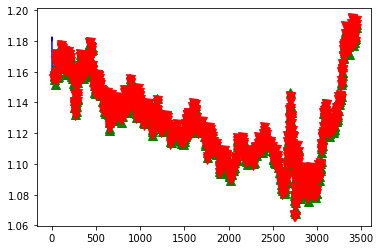

In [6]:
import os

import pandas as pd
pd.options.mode.chained_assignment = None
import time
from collections import deque
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

n_input = 18
n_hidden = 50
n_class = 1
class biLSTM_Attention(nn.Module):

    def __init__(self):

        super(biLSTM_Attention, self).__init__()
        self.bilstm = nn.LSTM(n_input, n_hidden, batch_first =True,bidirectional=True, dropout=0.5)  
        self.linear_1 = nn.Linear(n_input, n_input)
        self.linear_2 = nn.Linear(n_hidden * 2, n_class)

        self.w_omega = nn.Parameter(torch.Tensor(n_hidden * 2, n_hidden * 2))
        self.u_omega = nn.Parameter(torch.Tensor(n_hidden * 2, 1))
        
        nn.init.uniform_(self.w_omega, -0.1, 0.1)
        nn.init.uniform_(self.u_omega, -0.1, 0.1)

    def attention_net(self,x):
      u = torch.tanh(torch.matmul(x, self.w_omega))  
      att = torch.matmul(u, self.u_omega)
      att_score = F.softmax(att, dim=1) 
      scored_x = x * att_score
      context = torch.sum(scored_x, dim=1)
      return context

    def forward(self, x):
        x = self.linear_1(x)
        #h_n of shape (num_layers * num_directions, batch, hidden_size): tensor containing the hidden state for t = seq_len.
        bilstm_out, (h_n,c_n) = self.bilstm(x)
        
        attn_output = self.attention_net(bilstm_out) 
        z = self.linear_2(attn_output)
        return z.view(-1)

net = torch.load('bilstm_model (1).pt')



#from signalHandler import signalHandler
#from visualise import visualise
#from trading_strategy import trading_strategy

############# READ FILE #############

data = pd.read_csv('for_backtesting_EUR_USD.csv',index_col=False )#, skiprows=1)#, names = ['date', 'time', 'open', 'high', 'low', 'close', 'tickvol','vol','spread' ])

#data = pd.read_csv('EURUSD_M30.csv',sep=',', skiprows=1, names = ['time', 'open', 'high', 'low', 'close', 'tickvol','vol','spread' ])
#data = pd.read_csv('EURUSD_M30.csv',sep='\t', skiprows=1, names = ['date', 'time', 'open', 'high', 'low', 'close', 'tickvol','vol','spread' ])
#data = data.drop(['tickvol', 'vol','spread'], axis=1)  # we do not need these coloumns



############# Hyperparameters #############
input_row_size = 20         # <----- Minimum number of inputs required by YOUR trading strategy
one_pip = 0.0001            # <----- Indicating the value of 1 pip, i.e. usually 0.0001 for all major fx except for JPY pairs (0.01)
stop_loss = -10*one_pip     # <----- (THIS WILL CHANGE!!, if the code recieves opposite signal than previously executed order then the position will be closed. 
take_profit = 20*one_pip    # <----- For example. If we holding a buy pisition and sell signal received (labeled as buyy_sell in signalHandler.py) then the position will be closed. 
broker_cost = 2*one_pip
inputs = deque(maxlen=input_row_size)
############# BACKTESTING #############
# Handels Buy and Sell
broker = signalHandler(stop_loss,take_profit,broker_cost,data)

start_time = time.time() 
index = 0
signal = 0
for _,row in data.iterrows():

    # Loading the inputs array till the 
    # minimum number of inputs are reached
    inputs.append(row)
    
    if len(inputs) == input_row_size:
        signal = trading_strategy_my(list(inputs),net) #  call trading strategy. It will return one of the following 1 (Buy), 0 (do nothing) or -1 (sell)

        # Current Price
        current_price = row['close']  
        
        # Checks signal and executes
        if signal == 1:
            broker.buy(current_price,index)
        elif signal == -1:
            broker.sell(current_price,index)
        elif signal == 0:
            # Checking if stop loss or take profit is hit
            broker.checkStopConditions(current_price,index)
        else:
            print("Unknown Signal")
            break
     
    index += 1

end_time = time.time()
print("Time consumed: {}s".format(round(end_time-start_time,2)))

final_data = broker.getData() # <----- Gets Data into a DATAFRAME
final_data.to_csv('/content/EUR_USD_1.csv')
# final_data has THREE new coloumns
#   'action'        : The action the code implemented at that timestep.
#   'P/L'           : The profit or loss at the time step, 0 when holding.
#   'Total profit'  : The total profit TILL that time step. 

############# VISUALISEING #############
visualiser = visualise(final_data)
visualiser.plotFig()